In [91]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import math
import sys
import statistics

import yfinance as yf
yf.pdr_override()

dataset = pd.read_csv('db/acoes1.csv')
dataset


,Date,VALE3.SA,KEPL3.SA,VULC3.SA,LEVE3.SA,GGBR4.SA,LREN3.SA,ALSO3.SA,DIRR3.SA,MILS3.SA,...,CMIG4.SA,ITSA4.SA,BBAS3.SA,TASA4.SA,SLCE3.SA,B3SA3.SA,PETR4.SA,SUZB3.SA,KLBN4.SA,BOVA11.SA
0,2012-02-01,45.599998,2.00,8.000000,16.316666,16.571428,9.630643,24.000000,9.970000,21.889999,...,12.346126,5.575240,27.480000,18.700001,6.921487,3.846666,24.950001,20.010000,1.596,63.520000
1,2012-02-02,45.570000,2.00,8.000000,16.533333,16.809523,9.799544,24.290001,10.050000,21.469999,...,12.286963,5.594366,27.400000,18.920000,6.900826,3.893333,24.530001,20.010000,1.552,63.590000
2,2012-02-03,45.869999,2.00,7.440000,16.663334,17.295238,9.975004,24.500000,10.100000,21.980000,...,12.269552,5.608710,27.299999,19.139999,6.892561,3.946666,24.610001,20.010000,1.552,64.209999
3,2012-02-06,45.849998,2.00,7.440000,16.633333,17.333332,10.002881,24.580000,10.170000,21.540001,...,12.387913,5.618273,27.150000,19.030001,6.838842,3.946666,24.860001,20.010000,1.532,64.190002
4,2012-02-07,45.840000,2.00,7.440000,16.566666,17.428572,9.873336,24.520000,10.170000,21.500000,...,12.342644,5.675651,27.250000,19.139999,6.979338,3.970000,25.600000,20.010000,1.550,64.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,2023-10-18,65.360001,10.44,18.540001,38.900002,21.660000,12.240000,21.990000,16.700001,10.600000,...,11.680000,8.750000,49.119999,15.480000,36.310001,11.130000,38.520000,56.080002,4.660,110.370003
2908,2023-10-19,64.419998,10.42,18.580000,38.759998,21.629999,12.340000,21.959999,16.750000,10.420000,...,11.780000,8.800000,49.500000,15.470000,36.689999,11.000000,38.340000,55.980000,4.650,110.599998
2909,2023-10-20,62.680000,10.46,18.290001,38.849998,21.450001,12.220000,22.020000,16.709999,10.600000,...,11.810000,8.740000,49.340000,15.340000,36.270000,11.150000,37.849998,54.900002,4.550,109.500000
2910,2023-10-23,62.560001,10.60,18.330000,38.000000,21.760000,12.400000,22.860001,17.049999,10.630000,...,11.910000,8.730000,49.270000,15.770000,36.500000,11.310000,35.349998,54.400002,4.480,109.349998


In [92]:
dataset

,Date,VALE3.SA,KEPL3.SA,VULC3.SA,LEVE3.SA,GGBR4.SA,LREN3.SA,ALSO3.SA,DIRR3.SA,MILS3.SA,...,CMIG4.SA,ITSA4.SA,BBAS3.SA,TASA4.SA,SLCE3.SA,B3SA3.SA,PETR4.SA,SUZB3.SA,KLBN4.SA,BOVA11.SA
0,2012-02-01,45.599998,2.00,8.000000,16.316666,16.571428,9.630643,24.000000,9.970000,21.889999,...,12.346126,5.575240,27.480000,18.700001,6.921487,3.846666,24.950001,20.010000,1.596,63.520000
1,2012-02-02,45.570000,2.00,8.000000,16.533333,16.809523,9.799544,24.290001,10.050000,21.469999,...,12.286963,5.594366,27.400000,18.920000,6.900826,3.893333,24.530001,20.010000,1.552,63.590000
2,2012-02-03,45.869999,2.00,7.440000,16.663334,17.295238,9.975004,24.500000,10.100000,21.980000,...,12.269552,5.608710,27.299999,19.139999,6.892561,3.946666,24.610001,20.010000,1.552,64.209999
3,2012-02-06,45.849998,2.00,7.440000,16.633333,17.333332,10.002881,24.580000,10.170000,21.540001,...,12.387913,5.618273,27.150000,19.030001,6.838842,3.946666,24.860001,20.010000,1.532,64.190002
4,2012-02-07,45.840000,2.00,7.440000,16.566666,17.428572,9.873336,24.520000,10.170000,21.500000,...,12.342644,5.675651,27.250000,19.139999,6.979338,3.970000,25.600000,20.010000,1.550,64.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,2023-10-18,65.360001,10.44,18.540001,38.900002,21.660000,12.240000,21.990000,16.700001,10.600000,...,11.680000,8.750000,49.119999,15.480000,36.310001,11.130000,38.520000,56.080002,4.660,110.370003
2908,2023-10-19,64.419998,10.42,18.580000,38.759998,21.629999,12.340000,21.959999,16.750000,10.420000,...,11.780000,8.800000,49.500000,15.470000,36.689999,11.000000,38.340000,55.980000,4.650,110.599998
2909,2023-10-20,62.680000,10.46,18.290001,38.849998,21.450001,12.220000,22.020000,16.709999,10.600000,...,11.810000,8.740000,49.340000,15.340000,36.270000,11.150000,37.849998,54.900002,4.550,109.500000
2910,2023-10-23,62.560001,10.60,18.330000,38.000000,21.760000,12.400000,22.860001,17.049999,10.630000,...,11.910000,8.730000,49.270000,15.770000,36.500000,11.310000,35.349998,54.400002,4.480,109.349998


In [93]:
dataset = pd.read_csv('db/acoes1.csv')
dataset.drop(columns= ["Date"], inplace=True)
dataset['soma valor'] = dataset.sum(axis = 1)
dataset

,VALE3.SA,KEPL3.SA,VULC3.SA,LEVE3.SA,GGBR4.SA,LREN3.SA,ALSO3.SA,DIRR3.SA,MILS3.SA,RANI3.SA,...,ITSA4.SA,BBAS3.SA,TASA4.SA,SLCE3.SA,B3SA3.SA,PETR4.SA,SUZB3.SA,KLBN4.SA,BOVA11.SA,soma valor
0,45.599998,2.00,8.000000,16.316666,16.571428,9.630643,24.000000,9.970000,21.889999,1.015,...,5.575240,27.480000,18.700001,6.921487,3.846666,24.950001,20.010000,1.596,63.520000,390.625057
1,45.570000,2.00,8.000000,16.533333,16.809523,9.799544,24.290001,10.050000,21.469999,1.015,...,5.594366,27.400000,18.920000,6.900826,3.893333,24.530001,20.010000,1.552,63.590000,390.950688
2,45.869999,2.00,7.440000,16.663334,17.295238,9.975004,24.500000,10.100000,21.980000,1.015,...,5.608710,27.299999,19.139999,6.892561,3.946666,24.610001,20.010000,1.552,64.209999,393.133864
3,45.849998,2.00,7.440000,16.633333,17.333332,10.002881,24.580000,10.170000,21.540001,1.015,...,5.618273,27.150000,19.030001,6.838842,3.946666,24.860001,20.010000,1.532,64.190002,392.764045
4,45.840000,2.00,7.440000,16.566666,17.428572,9.873336,24.520000,10.170000,21.500000,1.015,...,5.675651,27.250000,19.139999,6.979338,3.970000,25.600000,20.010000,1.550,64.949997,394.477004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,65.360001,10.44,18.540001,38.900002,21.660000,12.240000,21.990000,16.700001,10.600000,11.070,...,8.750000,49.119999,15.480000,36.310001,11.130000,38.520000,56.080002,4.660,110.370003,656.840008
2908,64.419998,10.42,18.580000,38.759998,21.629999,12.340000,21.959999,16.750000,10.420000,11.200,...,8.800000,49.500000,15.470000,36.689999,11.000000,38.340000,55.980000,4.650,110.599998,655.729990
2909,62.680000,10.46,18.290001,38.849998,21.450001,12.220000,22.020000,16.709999,10.600000,11.320,...,8.740000,49.340000,15.340000,36.270000,11.150000,37.849998,54.900002,4.550,109.500000,649.520000
2910,62.560001,10.60,18.330000,38.000000,21.760000,12.400000,22.860001,17.049999,10.630000,11.400,...,8.730000,49.270000,15.770000,36.500000,11.310000,35.349998,54.400002,4.480,109.349998,650.060000


In [94]:
0.003240595095689134*250

0.8101487739222835

In [95]:
def alocacao_portfolio(dataset, dinheiro_total, sem_risco, repeticoes):
  dataset = dataset.copy()
  dataset_original = dataset.copy()

  lista_retorno_esperado = []
  lista_volatilidade_esperada = []
  lista_sharpe_ratio = []

  melhor_sharpe_ratio = 1 - sys.maxsize
  melhores_pesos = np.empty
  melhor_volatilidade = 0
  melhor_retorno = 0
  
  for _ in range(repeticoes):
    pesos = np.random.random(len(dataset.columns) - 1)
    pesos = pesos / pesos.sum()

    for i in dataset.columns[1:]:
      dataset[i] = dataset[i] / dataset[i][0]

    for i, acao in enumerate(dataset.columns[1:]):
      dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    dataset.drop(labels = ['Date'], axis = 1, inplace=True)

    retorno_carteira = np.log(dataset / dataset.shift(1))
    matriz_covariancia = retorno_carteira.cov()

    dataset['soma valor'] = dataset.sum(axis = 1)
    dataset['taxa retorno'] = 0.0

    # for i in range(1, len(dataset)):
    #   dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1])

    #sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)
    retorno_esperado = (np.log(dataset / dataset.shift(1))).mean().sum() * 250 **0.5  #np.sum(dataset['taxa retorno'].mean() * pesos) * 246
    volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 246, pesos)))
    sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

    if sharpe_ratio > melhor_sharpe_ratio:
      melhor_sharpe_ratio = sharpe_ratio
      melhores_pesos = pesos
      melhor_volatilidade = volatilidade_esperada
      melhor_retorno = retorno_esperado

    lista_retorno_esperado.append(retorno_esperado)
    lista_volatilidade_esperada.append(volatilidade_esperada)
    lista_sharpe_ratio.append(sharpe_ratio)
    
    dataset = dataset_original.copy()

  return melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno

In [96]:
dataset

,VALE3.SA,KEPL3.SA,VULC3.SA,LEVE3.SA,GGBR4.SA,LREN3.SA,ALSO3.SA,DIRR3.SA,MILS3.SA,RANI3.SA,...,ITSA4.SA,BBAS3.SA,TASA4.SA,SLCE3.SA,B3SA3.SA,PETR4.SA,SUZB3.SA,KLBN4.SA,BOVA11.SA,soma valor
0,45.599998,2.00,8.000000,16.316666,16.571428,9.630643,24.000000,9.970000,21.889999,1.015,...,5.575240,27.480000,18.700001,6.921487,3.846666,24.950001,20.010000,1.596,63.520000,390.625057
1,45.570000,2.00,8.000000,16.533333,16.809523,9.799544,24.290001,10.050000,21.469999,1.015,...,5.594366,27.400000,18.920000,6.900826,3.893333,24.530001,20.010000,1.552,63.590000,390.950688
2,45.869999,2.00,7.440000,16.663334,17.295238,9.975004,24.500000,10.100000,21.980000,1.015,...,5.608710,27.299999,19.139999,6.892561,3.946666,24.610001,20.010000,1.552,64.209999,393.133864
3,45.849998,2.00,7.440000,16.633333,17.333332,10.002881,24.580000,10.170000,21.540001,1.015,...,5.618273,27.150000,19.030001,6.838842,3.946666,24.860001,20.010000,1.532,64.190002,392.764045
4,45.840000,2.00,7.440000,16.566666,17.428572,9.873336,24.520000,10.170000,21.500000,1.015,...,5.675651,27.250000,19.139999,6.979338,3.970000,25.600000,20.010000,1.550,64.949997,394.477004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,65.360001,10.44,18.540001,38.900002,21.660000,12.240000,21.990000,16.700001,10.600000,11.070,...,8.750000,49.119999,15.480000,36.310001,11.130000,38.520000,56.080002,4.660,110.370003,656.840008
2908,64.419998,10.42,18.580000,38.759998,21.629999,12.340000,21.959999,16.750000,10.420000,11.200,...,8.800000,49.500000,15.470000,36.689999,11.000000,38.340000,55.980000,4.650,110.599998,655.729990
2909,62.680000,10.46,18.290001,38.849998,21.450001,12.220000,22.020000,16.709999,10.600000,11.320,...,8.740000,49.340000,15.340000,36.270000,11.150000,37.849998,54.900002,4.550,109.500000,649.520000
2910,62.560001,10.60,18.330000,38.000000,21.760000,12.400000,22.860001,17.049999,10.630000,11.400,...,8.730000,49.270000,15.770000,36.500000,11.310000,35.349998,54.400002,4.480,109.349998,650.060000


In [97]:
dinheiro_total = 5000
taxa_selic_2010 = 12.5
taxa_selic_2011 = 9.25
taxa_selic_2012 = 7.25
taxa_selic_2013 = 7.75
taxa_selic_2014 = 9.5
taxa_selic_2015 = 14.25
taxa_selic_2016 = 14.25
taxa_selic_2017 = 14.25
taxa_selic_2018 = 6.5
taxa_selic_2019 = 5.25
taxa_selic_2020 = 2.25
taxa_selic_2021 = 7.75
taxa_selic_2022 = 11.75
taxa_selic_2023 = 12.5

valor_2010 = dinheiro_total + (dinheiro_total * taxa_selic_2010 / 100)
valor_2011 = valor_2010 + (dinheiro_total * taxa_selic_2011 / 100)
valor_2012 = valor_2011 + (dinheiro_total * taxa_selic_2012 / 100)
valor_2013 = valor_2012 + (dinheiro_total * taxa_selic_2013 / 100)
valor_2014 = valor_2013 + (dinheiro_total * taxa_selic_2014 / 100)
valor_2015 = valor_2014 + (dinheiro_total * taxa_selic_2015 / 100)
valor_2016 = valor_2015 + (dinheiro_total * taxa_selic_2016 / 100)
valor_2017 = valor_2016 + (dinheiro_total * taxa_selic_2017 / 100)
valor_2018 = valor_2017 + (dinheiro_total * taxa_selic_2018 / 100)
valor_2019 = valor_2018 + (dinheiro_total * taxa_selic_2019 / 100)
valor_2020 = valor_2019 + (dinheiro_total * taxa_selic_2020 / 100)
valor_2021 = valor_2020 + (dinheiro_total * taxa_selic_2021 / 100)
valor_2022 = valor_2021 + (dinheiro_total * taxa_selic_2022 / 100)
valor_2023 = valor_2022 + (dinheiro_total * taxa_selic_2023 / 100)
valor_2023
taxa_selic_historico = np.array([taxa_selic_2010, taxa_selic_2011, taxa_selic_2012, taxa_selic_2013, taxa_selic_2014, taxa_selic_2015, taxa_selic_2016, taxa_selic_2017, taxa_selic_2018, taxa_selic_2019, taxa_selic_2020, taxa_selic_2021, taxa_selic_2022, taxa_selic_2023])
dataset_original = dataset.copy()
dinheiro_total = 5000
sem_risco = taxa_selic_historico.mean() / 100
sem_risco


# (dataset['taxa de retorno'].mean() - taxa_selic_historico.mean()/100)/ dataset['taxa de retorno'].std() * math.sqrt(246) #sharp ratio validando historico da selic


0.09642857142857142

In [98]:
sharpe_ratio, melhores_pesos, ls_retorno, ls_volatilidade, ls_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_portfolio(pd.read_csv('db/acoes1.csv'), 5000, taxa_selic_historico.mean() / 100, 150)

In [99]:
sharpe_ratio, melhores_pesos

(-0.09916953462697381,
 array([0.06826908, 0.00668037, 0.07075685, 0.00923863, 0.02129788,
        0.00076917, 0.05238634, 0.0360719 , 0.04179412, 0.09234709,
        0.00385223, 0.01920011, 0.02120811, 0.01794847, 0.05550069,
        0.08585561, 0.02855961, 0.01474371, 0.0992588 , 0.10735549,
        0.03447399, 0.02998528, 0.08244645]))

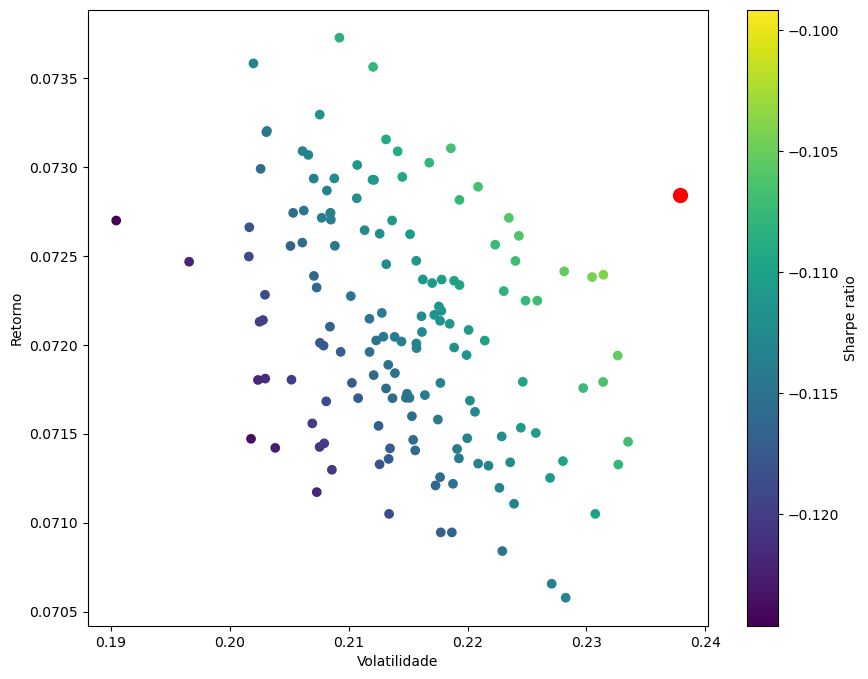

In [100]:
plt.figure(figsize=(10,8))
plt.scatter(ls_volatilidade, ls_retorno, c = ls_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red', s = 100);